Yalnızca tek bir gizli katman içeren CNN

Gereksinimler:

In [ ]:
!pip install numpy
!pip install tensorflow
!pip install keras
!pip install opencv-python
!pip install pandas

Veriyi zip'ten çıkarma:

In [2]:
import zipfile

# zip dosyasının yolu
zip_file_path = "/content/drive/MyDrive/ChestXray.zip"

# zip dosyasını aç
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/veri")

Veriyi parçalara bölme:

In [12]:
import os
import cv2
import numpy as np

def load_data():
    normal_path = '/content/veri/ChestXray/NORMAL'
    pneumonia_path = '/content/veri/ChestXray/PNEUMONIA'
    
    normal_images = []
    pneumonia_images = []
    labels = []
    
    for filename in os.listdir(normal_path):
        img = cv2.imread(os.path.join(normal_path, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (256, 256))
        normal_images.append(img)
        labels.append(0)
        
    for filename in os.listdir(pneumonia_path):
        img = cv2.imread(os.path.join(pneumonia_path, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (256, 256))
        pneumonia_images.append(img)
        labels.append(1)
        
    normal_images = np.array(normal_images)
    pneumonia_images = np.array(pneumonia_images)
    labels = np.array(labels)
    
    return normal_images, pneumonia_images, labels
normal_images,pneumonia_images,labels=load_data()

Veriyi train-test olarak bölme:

In [13]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.utils import to_categorical

all_images = np.concatenate((normal_images, pneumonia_images))
all_images = np.expand_dims(all_images, axis=-1) # kanal boyutunu ekleyin
all_labels = np.concatenate((np.zeros(len(normal_images)), np.ones(len(pneumonia_images))))
x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2)

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

İleri Beslemeli Sinir Ağı modeli ve eğitim:

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
img_size = (256, 256)
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

hidden_layers = 2 # istediğiniz gizli katman sayısı

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_size[0], img_size[1], 1)))
model.add(MaxPooling2D((2,2)))

for i in range(hidden_layers):
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=40, batch_size=64,callbacks=[early_stop])

Epoch 1/40
42/42 [==============================] - 6s 104ms/step - loss: 47.5195 - accuracy: 0.7288 - val_loss: 0.2587 - val_accuracy: 0.8938
Epoch 2/40
42/42 [==============================] - 4s 93ms/step - loss: 0.1906 - accuracy: 0.9275 - val_loss: 0.1871 - val_accuracy: 0.9378
Epoch 3/40
42/42 [==============================] - 4s 93ms/step - loss: 0.1365 - accuracy: 0.9510 - val_loss: 0.1411 - val_accuracy: 0.9484
Epoch 4/40
42/42 [==============================] - 4s 93ms/step - loss: 0.0954 - accuracy: 0.9628 - val_loss: 0.1385 - val_accuracy: 0.9575
Epoch 5/40
42/42 [==============================] - 4s 93ms/step - loss: 0.0770 - accuracy: 0.9715 - val_loss: 0.1537 - val_accuracy: 0.9484
Epoch 6/40
42/42 [==============================] - 4s 94ms/step - loss: 0.0532 - accuracy: 0.9810 - val_loss: 0.1638 - val_accuracy: 0.9378
Epoch 7/40
42/42 [==============================] - 4s 93ms/step - loss: 0.0683 - accuracy: 0.9761 - val_loss: 0.1619 - val_accuracy: 0.9439
Epoch 8/40


Loss-Accuracy tablosu:

<Axes: >

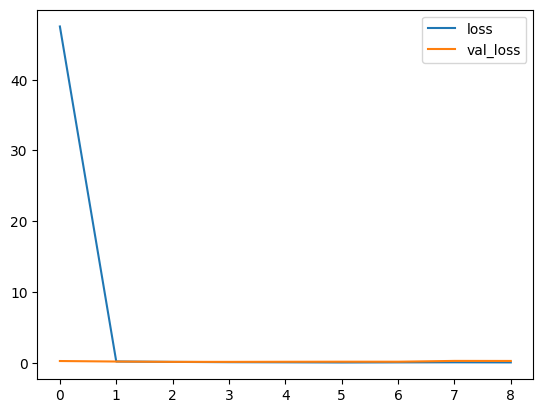

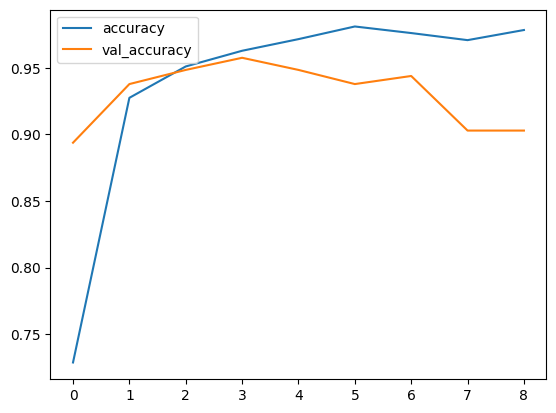

In [19]:
import pandas as pd
df = pd.DataFrame(model.history.history)
loss=df.drop(["accuracy","val_accuracy"],axis=1)
accuracy=df.drop(["loss","val_loss"],axis=1)
loss.plot()
accuracy.plot()

Test:

In [20]:
loss, accuracy = model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

21/21 [==============================] - 0s 17ms/step - loss: 0.2685 - accuracy: 0.9029
Test Loss: 0.2685064375400543
Test Accuracy: 0.9028831720352173
